---
# Brain-Computer Interface data classification
---

In this challenge you will focus on a "guided tour" to building a statistical model to work with a very peculiar kind of data: as such, this project will require you to spend more time reading scientific papers than coding. The proposed field gives you an opportunity to compare traditional machine learning approaches and Deep Learning. To improve the performance of a baseline model you will have to build/modify existing neural network architectures and you will have to perform such modifications in a reasonable way (i.e. naive stacking of layers will not help). Also, you will have to pay particular attention to model regularization, because you will have a relatively small training dataset.

**IMPORTANT**: please refer to the AML course guidelines concerning grading rules. Pay especially attention to the **presentation quality** item, which boils down to: don't dump a zillion of lines of code and plots in this notebook. Produce a concise summary of your findings: this notebook can exist in two versions, a "scratch" version that you will use to work and debug, a "presentation" version that you will submit. The "presentation" notebook should go to the point, and convay the main findings of your work.

---
## Overview
In this challenge, we propose to create a classifier for a Brain-Computer Interface (BCI). Such a device intended to map mental states to computer commands. There are plenty of ways to organize such mapping. The most important feature which characterizes a BCI is the psychophysiological paradigm. A normal person, while interacting with a computer, goes throw a very large number of mental states. It’s impossible to process and classify them all.  The “paradigm” is a way to induce BCI users to a finite number of mental states during the experiment. You may find a survey of BCI paradigms here:

https://www.researchgate.net/publication/328974192_A_comprehensive_review_of_EEG-based_brain-computer_interface_paradigms

The data-processing pipeline strongly differs between different paradigms. The proposed dataset corresponds to a very unique BCI paradigm: the so-called Eye-Brain-Computer Interface (EBCI). You can read more about this in the following link: 

https://www.frontiersin.org/articles/10.3389/fnins.2016.00528/full

The dataset has been produced based on the survey cited in the link above. A good advice is to have a look at the survey, at least to understand the key ideas and differences between Event-Related-Potential (ERP and its subclass - P300), BCI, Motor Imaging BCI, and Error-Related Potential BCI. This is important because one of the easiest ways to solve the problem of this challenge is by adopting an existing BCI classifier, and adapt it to the proposed dataset. Indeed, some BCI paradigms produce data that strongly differ from EBCI data and its classifiers will work very poorly with the data we use in this challenge. IMPORTANT: you should work only with classifiers that are intended to work with electroencephalography - EEG (NOT MEG, NIRS or (f)MRI).

### EBCI paradigm
The key idea of EBCI is to replace a computer mouse with an eye tracker and electroencephalography. The eyetracker controls the position of a mouse cursor on the screen and EEG data is used to perform the equivalent of mouse clicks. When a user’s eye focuses on some element of a GUI (a button for example) the EEG classifier should take a decision, if the user has the intention to click on this GUI element or not. Possible classes could be, for example: just reading text on the button, thinking, is it worth to push this big red button, daydreaming or anything like that.

### Data collecting procedure (optional reading material)
During the experiment, a BCI user has to play a simple game - align balls of one color in lines. A transaction to collect individual data looks as follows. First, the user investigates the playing field and makes a decision about which ball to move. During this part of game, the EEG fragments corresponding to eye focus are collected and labeled as Non-Target (because the user has just been observing the playing field). Then, when a decision is made, the user focuses on the “Control mode ON” button. In this mode, each eye focus of 500 ms length is treated as a mouse click. Then the user focuses on the ball to move (this ball becomes highlighted). Then the user focuses on the free cell of the board to place this ball. These focusing actions are intentional, and the corresponding EEG fragments are labeled as Target. 

---
## Data exploration
For classification purposes you will have only small fragments of EEG, corresponding to eye focus. In psychophysiology, such key pieces of an EEG called epochs (do not confuse with neural network training epochs). One EEG epoch corresponds to one image, for example in image classification tasks. The EEG record has 19 channels (sensors placed to different parts of the user’s head). The sensors put in 10-20 EEG system, you can find a mapping from channel index to its name and channel coordinates in the order&locations.info file. The coordinates in this file are polar. First column is angle and second column is radius. The zero angle corresponds to the line connecting the top of the head and nose if we will look on the head from above (line between Cz and NASION on the picture below). 

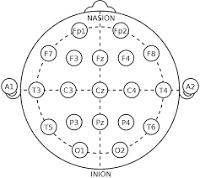

                                       Fig.1. 10-20 electrode placing system.

**NOTE**: The following discussion is a summary of what is described in the BCI paradigms survey linked above. For clarifications, refer to the BCI survey.

The sampling frequency of EEG equals 500 Hz. Data were processed with a band-pass filter (0.1 Hz-40 Hz). Each EEG epoch has a length of 1.5 seconds: 0.5 seconds before the focus onset and 1 second after focus onset. Focus onset is the beginning of eye focus. <font color=red>Further, we count the time from the beginning of the focus and not from the beginning of the whole EEG epoch.</font> So, focus onset is zero on the time axis. Only 500ms after focus onset of the EEG epoch corresponds to an eye focus. Additionally, the first 200ms of focus can be polluted with eye-movement artifacts. Due to the peculiarities of the data collecting procedure, these artifacts contain information about the class label. The interface should make a decision exactly after 500ms from the focus onset. Due to the data collection procedure, EEG after 500 ms contains information about labels too. 

In conclusion, **you can only use** the 200 ms to 500 ms time interval after the focus onset. Using all other parts of the EEG epoch will be <font color=red>considered wrong</font>, because of the label leakage problem mentioned above.
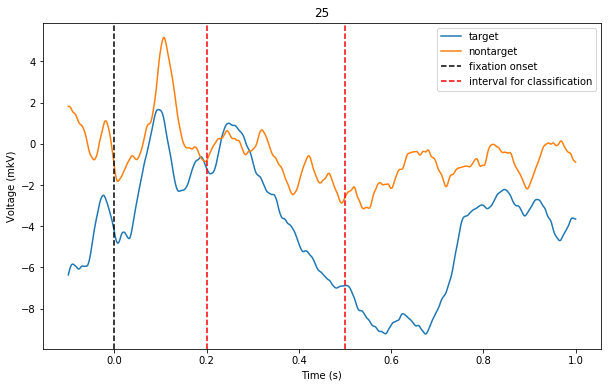

       Fig.2. Data from one of the EEG channels averaged over the target and non-target EEG epochs.

There are 13 subjects in the dataset (25-38): data for each subject is stored in a folder with the corresponding number. Each folder contains two .mat files - eegNT.mat with non-target EEG epochs and eegT.mat with target EEG epochs. Each file contain a three-dimensional array of shape (Time x Channels x Epochs).

It is strongly advised to load the data provided with the challenge using the example code available following this [link](https://github.com/LIKANblk/ebci_data_loader).

Using the ```DataBuildClassifier``` class in ```data.py```, the ```get_data``` method returns a dictionary with the subject’s number as key and tuples of EEG epochs and labels as data. Here EEG epochs array dimensions will be EEG epochs (Trials) x Time dim x Channel dim. You can have a look at the ```main``` method to see this in action. 

You don’t have to change any parameters except ```path_to_data``` and ```resample_to```. The latter can be treated as hyperparameter for the classification problem you will work on, because most of the classifiers work with EEG data with a reduced sample rate. So you can vary this parameter from 1 to 500 Hz. But it is suggested to not resample data at a lower frequency than 80 Hz.

The following code snippet is an example to help you in this preliminary data loading phase.

```python
import sys
sys.path.append('/home/likan_blk/BCI/data_loader')  #Path to data_loader code, cloned from github
from data import DataBuildClassifier

data_loader = DataBuildClassifier('/home/likan_blk/BCI/NewData') #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
all_subjects = [25, 26,27,28,29,30,32,33,34,35,36,37,38]
subjects = data_loader.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),resample_to=500)
print(subjects.keys())
X,y = subjects[25]
print(X.shape) #EEG epochs (Trials) x Time x Channels
print(y.shape)
```

If you are curious, the ```windows``` parameter contains a list of tuples with start and end time offset(s) of window(s) used for classification (in seconds). In your case, you will use only one window - [(0.2,0.5)].


```baseline_window``` - tuple with start and end time offset(s) of window(s) used for baseline correction (in seconds). You can learn more about the baseline correction concept in the Data Preprocessing section.
* In general, the only thing you have to do in this section is to plot averaged EEG epochs for each subject for Pz channel with the chosen after Parameters Optimization section sample rate.


---
## Data Preprocessing
The data you will work with already overcomes basic EEG preprocessing steps - band-pass filtering, electrode referencing, baseline correction and resampling. The only thing you can play with is resampling, implemented in the ```DataBuildClassifier``` class and controlled via the ```resample_to``` parameter. The dimensionality of the data is very large, comparing to the size of the dataset, so it is wise to tune this parameter during Hyperparameter (HP) search once a base model is working for you.


_Baseline correction_ is a technique used instead of Standardization or Normalization in EEG processing: it uses a section of the EEG epoch, in which the signal can be considered stable and artifact-free. The signal amplitude is averaged in this interval and subtracted from the corresponding EEG channel. So, this procedure is performed channel-wise.  It is strongly advised to keep the default value of this parameter  ```baseline_window=(0.2,0.3)```. As such, the baseline correction time interval is from 200ms to 300ms. Also, you should not use additional Standardization or Normalization.

NOTE: the above discussion pertains to code that is already implemented for you, in the ```get_data``` method.

---
## Model selection
**[Hint]** *This is the main part of the challenge. Please, have a look at the paper linked for the baseline architecture suggested at the end of the cell. Make sure that you understand the roles of each part of the proposed Neural Network. To create your own model please use hints from the Extensions and hints section at the end of the notebook.*

In this section, we first introduce the basic building blocks to build your statistical model for EEG data. We use *pipeline* as a synonim to represent a compound block of operations that consitute the model.
The proposed method is tailored to BCI with short EEG intervals, but its structure is general. Note also that the first stages of the following pipeline can be considered as being part of a Deep neural network architecture.

 __Spatial filters -> Temporal filters -> Classifier__ 
 

__The spatial filter__ is a simple weighted average of the EEG channels. The idea of this filter is to construct a _source_ representation of information, observed on sensors. It is assumed that there are some number of sources of a useful signal (less than the number of channels) that exist in the brain and several spatial filters working in parallel can recover such sources. However, in practice, for the classification task underlying this challenge, such sources are virtual.  The procedure of recovering real, physiologically sensible sources is out of the scope of this challenge.

There are plenty of different ways to learn the weights of such filters. There are supervised and unsupervised approaches. The simplest example of learning such a filter is a Common Spatial Patterns - a supervised version of Principal Component Analysis (https://www.youtube.com/watch?v=zsOULC16USU). If you prefer to adopt a Deep Learning approach, such a filter can be considered as a convolutional layer with shape: (Channels x 1) (First dimension - spatial and second dimension - temporal). Such filter convolves all channels together for each point in the time domain,  therefore weight sharing is performed over the temporal dimension. Such a layer trained together with other parts of the classification pipeline via standard backpropagation.


__The temporal filter__ is used because different sets of sources produce signals within different frequency bands. A straightforward approach is using several bandpass frequency filters (for example - Butterworth filter of order 5) in parallel. A Deep learning approach can learn more complicated temporal patterns: in this case, you can use a convolutional layer of size (1 x T) (first dimension - spatial and second one - temporal). The length of the filter T, depends on the frequency band you want to learn. In this case, weight sharing is performed both over spatial and temporal dimensions (because T is less then EEG epoch length). T can be chosen during hyperparameter optimization.

Note that __Temporal__ and __Spatial__ filter blocks can be swapped i.e some pipelines starts from temporal filters block, and some start from spatial filter blocks.


**Classifier**. On top of this pipeline it is possible to use simple linear classifiers, Linear Discriminant Analysis (LDA), SVMs, single layer perceptrons. For example, our colleagues from INRIA proposed to use Rhiemanian geometry for this purpose (https://hal.inria.fr/hal-01394253/document). You can easily find their implementation on GitHub (https://github.com/alexandrebarachant/pyRiemann). 

The vanilla example of the described pipeline is Filter Bank Common Spatial Patterns (FBCSP)  - (https://www.researchgate.net/publication/281076368_A_Tutorial_on_EEG_Signal_Processing_Techniques_for_Mental_State_Recognition_in_Brain-Computer_Interfaces)

All approaches described above have already been implemented for EEG data. You can find them on GitHub and use them as building blocks for your pipeline. 

**Baseline solution**: For a baseline solution to the model architecture task, you can use the EEGNET_v4 classifier (https://arxiv.org/abs/1611.08024) with tuned hyperparameters. It’s a pretty straightforward implementation of the EEG classification pipeline in terms of convolutional neural networks. 

---
## Parameter Optimisation
To tune the hyperparameters of your model (especially those that are specific to time domain) you should be familiar with Signal Processing concepts. As you can see after the Data Exploration section, patterns are characterized by low-frequency oscillations and you have to be sure that you model is capable to work with low-frequencies. 
If you a not familiar with signal processing, it is always possible to use a brute force approach like Random Search or some more sophisticated techniques like the ones implemented in Optuna (https://optuna.org/) or SMAC (https://github.com/automl/SMAC3). 

**NOTE**: You should explain the technique of your choice to achieve parameter optimization.

---
## Model evaluation
**[Hint]** *Your performance metric is the AUC, which you should use to report your results and eventually compare variants of the baseline pipeline*


The testing set is the last 20% EEG epochs of each class of each subject. The code for dividing into train and test data is available from the data exploration section. **NOTE**: the shuffle parameter should be set to ```False``` because EEG epochs are sorted w.r.t time. 

To evaluate the performance of your model, you should use the ROC AUC as a classification metric. 

**IMPORTANT**: Do not use the test set for hyperparameter tuning. You should use your training data (the first 80% EEG epochs) and partition it to carve out a  validation set, to be used for hyperparameter tuning. Also, you can use cross-validation.

**IMPORTANT**: It is strongly adviced to perform classification experiments **WITHIN** subjects. This means that you will have to train a classifier for each subject separately. However, **the hyperparameters of your pipeline should be the same for all subjects**. 

Due to physiological reasons, data from each subject represents a separate data domain. In general, it is very difficult to merge data from different subjects without additional methods such as Transfer Learning.

---
## Model explanation (optional)
This section is additional and related to Parameter Optimization. It will help you to explain the parameters of the model. The easiest thing you can do here is a visualization of the distribution of weights of spatial filters on “human head” like plots (see fig.1) and frequency response of temporal filters closest to network input. If you see the noisy pictures it means that your model focused on artifacts and not the real signal. 

Another way to prove, that your model is sensible is the t-SNE visualization of the features before the last layer/classifier. Also, you can use techniques from used https://arxiv.org/abs/1611.08024 (section 3.3, DeepLift package) to construct a saliency maps for input data 



---
## Baseline
Here https://github.com/LIKANblk/AML_EEG_challenge.git you can find PyTorch implementation of the network architecture described in https://arxiv.org/abs/1611.08024. The hyperparameters of the network are tuned to work with EBCI data.

---
## Extensions and hints (optional)
There are numerous ways to create a model that improves over the baseline suggested above. First of all, it should be noted that this challenge is more about **regularization** rather than a simple classification challenge. Indeed, training sets are small, compared to the dimensionality of each EEG epoch. So it is a good practice to prefer simple models with a small number of trainable parameters. 

To improve over the baseline, here are a few ideas:

1. Make EEGNET_v4 better: 
    - Careful hyperparameter (HP) tuning. Baseline solution already uses some non-default values for HP, but you can revisit all HP values of the model (step sizes, padding values, filter sizes for pooling and convolution layers, etc)
    - You can improve the model with more sophisticated regularization techniques: augment training data with adversarial examples https://arxiv.org/abs/1412.6572 ; Variational Dropout; etc...
    - You can make model slightly deeper with an additional separable-convolution block or one block from MobileNet; or wider, to teach network work with temporal patterns of different scales (https://arxiv.org/abs/1603.06995)
2. Try neural network architectures from other types of BCI (https://iopscience.iop.org/article/10.1088/1741-2552/ab260c), (https://iopscience.iop.org/article/10.1088/1741-2552/ab0ab5). Chose only networks, suited to work with **short** EEG patterns - ERP, P300, or networks, suited for low-frequency oscillations  (ERN).


# Load the data 

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from src.data import DataBuildClassifier
import shutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from src.utils import single_auc_loging
from src.utils import prepare_dirs,write_results_table, separte_last_block
from src.model_torch import train_model_eegnet
import shutil
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import codecs


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import copy
import math
from IPython.display import clear_output
import pandas as pd

from src.model_torch import *


/mnt/workspace/AML/Chall4_ebci/src/utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", 

In [8]:
experiment_res_dir = './res/' #Path to save results and training|testing statistics
all_subjects = [25,26,27,28,29,30,32,33,34,35,36,37,38]
data = DataBuildClassifier('/mnt/datasets/eeg')

# Hyperparameters for the classifier

In [9]:
baseline_params = {'resample_to': 369,
                 'D': 3,
                 'F1': 12,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275,
                 'kernLength1' : 64,
                  'kernLength2' : 64,
              'poolKern1' : 4,  
              'poolKern2' : 8  
                 }

# Load the subjects

In [10]:
subjects = data.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),resample_to=baseline_params['resample_to'])

In [6]:
X, Y = subjects[25]

In [7]:
%matplotlib inline

In [8]:
def get_topography():
    '''
    Function returenss informantion about channel order and topography
    :return: Dict {Ch_number: [(x,y), Ch_name]}
    '''
    with open('/mnt/datasets/eeg/order_locations.info', 'r') as f:
        topo_list = [line.split() for line in f][1:]
    topo_dict = {}
    ch_coordinates = []
    ch_names = []
    for elem in topo_list:
        alpha, r = float(elem[1]), float(elem[2])
        alpha = math.pi * alpha / 180.  # to radians
        x, y = r * math.sin(alpha), r * math.cos(alpha)
        name = str(elem[3])
        # topo_dict[int(elem[0])] = [(x, y), name]
        ch_coordinates.append((x,y))
        ch_names.append(name)
    return ch_coordinates,ch_names


In [10]:
ch_coordinates,ch_names = get_topography()

In [11]:
df = pd.DataFrame({ 'Name' : ch_names ,\
                  'X' : [x[0] for x in ch_coordinates],
                   'Y' : [x[1] for x in ch_coordinates]
                  })

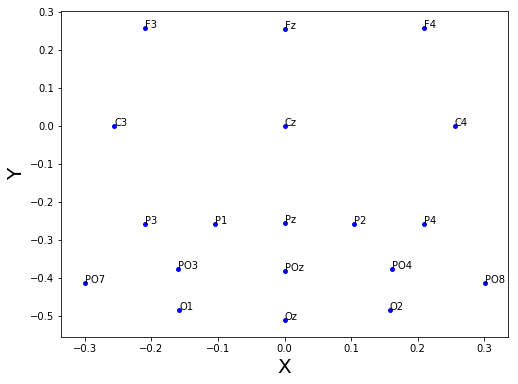

In [12]:
fig = plt.figure(1,figsize=(8,6))
plt.subplot(111)

plt.scatter(df['X'], df['Y'],  marker='o', color='b', s=15)

for i, row in df.iterrows():
    plt.annotate(row["Name"], xy=(row["X"],row["Y"]))

plt.xlabel('X',size=20)
plt.ylabel('Y',size=20)

plt.show()

In [13]:
X[25, :, 0].shape

(111,)

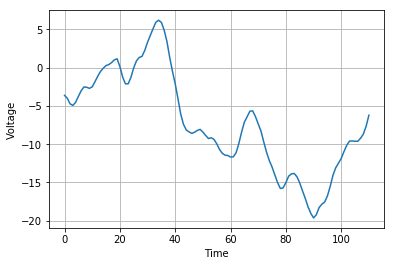

In [14]:
plt.plot(X[0, :, 0])
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()

Following block contains a defenition of crossvalidation function and loop, where model created and consequentially applied for each subjects data and per-subject training information saved to corresponding folders in experiment_res_dir. Please look carefully to cv_per_subj_test function.

In [5]:
class EEGNet_experimental(nn.Module):
    '''Data shape = (trials, kernels, channels, samples), which for the
        input layer, will be (trials, 1, channels, samples).'''
    #TODO resolve problems with avg padding when the end of the epoch lost
    #TODO possible solution via padding or AdaptiveAvgPool2d
    def __init__(self,nb_classes, Chans=64, Samples=128,
           dropoutRates=(0.25,0.25), kernLength1=64,kernLength2=16, poolKern1=4,poolKern2=8, F1=4,
           D=2, F2=8, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet_experimental,self).__init__()
        self.Chans = Chans
        self.Samples = Samples
        self.output_sizes = {}
        #block1
        time_padding = int((kernLength1//2))
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=F1,kernel_size =(1,kernLength1),padding=(0,time_padding), stride=1,bias=False)
        self.output_sizes['conv1']=convtransp_output_shape((Chans,Samples), kernel_size=(1,kernLength1), stride=1,
                                                           pad=(0,time_padding))
        self.batchnorm1 = nn.BatchNorm2d(num_features=F1, affine=True)
        self.depthwise1 = nn.Conv2d(in_channels=F1,out_channels=F1*D,kernel_size=(Chans,1),groups=F1,padding=0,bias=False)
        self.output_sizes['depthwise1'] = convtransp_output_shape(self.output_sizes['conv1'], kernel_size=(Chans,1),
                                                                  stride=1, pad=0)
        self.batchnorm2 = nn.BatchNorm2d(num_features=F1*D, affine=True)
        self.activation_block1 = nn.ELU()
        # self.avg_pool_block1 = nn.AvgPool2d((1,poolKern1))
        # self.output_sizes['avg_pool_block1'] = convtransp_output_shape(self.output_sizes['depthwise1'], kernel_size=(1, poolKern1),
        #                                                           stride=(1,poolKern1), pad=0)
        self.avg_pool_block1 = nn.AdaptiveAvgPool2d((1,int(self.output_sizes['depthwise1'][1]/4)))
        self.output_sizes['avg_pool_block1'] = (1,int(self.output_sizes['depthwise1'][1]/4))
        self.dropout_block1 = nn.Dropout(p=dropoutRates[0])

        #block2
        self.separable_block2 = deepwise_separable_conv(nin=F1*D,nout=F2,kernelSize=kernLength2)
        self.output_sizes['separable_block2'] = self.separable_block2.get_output_size(self.output_sizes['avg_pool_block1'])
        self.activation_block2 = nn.ELU()
        # self.avg_pool_block2 = nn.AvgPool2d((1,poolKern2))
        # self.output_sizes['avg_pool_block2'] = convtransp_output_shape(self.output_sizes['separable_block2'],
        #                                                                kernel_size=(1, poolKern2),
        #                                                                stride=(1, poolKern2), pad=0)
        self.avg_pool_block2 = nn.AdaptiveAvgPool2d((1,int(self.output_sizes['separable_block2'][1]/4)))
        self.output_sizes['avg_pool_block2'] = (1,int(self.output_sizes['separable_block2'][1]/4))

        self.dropout_block2 = nn.Dropout(dropoutRates[1])

        self.flatten = Flatten()
        n_size = self.get_features_dim(Chans,Samples)
        self.dense = nn.Linear(n_size,nb_classes)

    def get_features_dim(self,Chans,Samples):
        bs = 1
        x = Variable(torch.rand((bs,1,Chans, Samples)))
        output_feat,out_dims = self.forward_features(x)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def forward_features(self,input):
        out_dims = {}
        block1 = self.conv1(input)
        out_dims['conv1'] = block1.size()
        block1 = self.batchnorm1(block1)
        block1 = self.depthwise1(block1)
        out_dims['depthwise1'] = block1.size()
        block1 = self.batchnorm2(block1)
        block1 = self.activation_block1(block1)
        block1 = self.avg_pool_block1(block1)
        out_dims['avg_pool_block1'] = block1.size()
        block1 = self.dropout_block1(block1)

        block2 = self.separable_block2(block1)
        out_dims['separable_block2'] = block1.size()
        block2 = self.activation_block2(block2)
        block2 = self.avg_pool_block2(block2)
        out_dims['avg_pool_block2'] = block1.size()
        block2 = self.dropout_block2(block2)
        return block2, out_dims

    def forward(self, input):
        features,_ = self.forward_features(input)
        flatten_feats = self.flatten(features)
        out = self.dense(flatten_feats)
        return out

    def weights_init(self):
        def weights_init(m):
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform(m.weight.data)

In [6]:
def train_model_eegnet(x_tr,y_tr,params,validation_data,epochs=200,batch_size=64, shuffle=True,model_path=None,\
                      kernLength1 = 64, kernLength2 = 64):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'
    x_val,y_val = validation_data

    F2 = params.get('F2',params['F1']*params['D'])
    model = EEGNet_experimental(nb_classes=2, Chans=x_tr.shape[2], Samples=x_tr.shape[3],
                               dropoutRates=(params['dropoutRate1'], params['dropoutRate1']),
                               kernLength1=params['kernLength1'],kernLength2 =  params['kernLength2'] ,poolKern1= params['poolKern1'] ,
                               poolKern2=params['poolKern2'],
                               F1=params['F1'],
                               D=params['D'], F2=F2)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    train_set = EBCIDataset((x_tr, y_tr))
    train_loader = DataLoader(train_set, batch_size=batch_size,
                              shuffle=shuffle, num_workers=0)

    history = {'loss': [], 'val_loss': [], 'val_auc': []}
    best_auc=0
    for epoch in range(epochs):
        model.train()
        running_tr_loss = 0.0
        for local_batch, local_labels in train_loader:
            optimizer.zero_grad()
            local_batch, local_labels = local_batch.to(device,dtype=torch.float), local_labels.to(device,dtype=torch.long)
            predictions = model(local_batch)
            loss = criterion(predictions,local_labels)
            loss.backward()
            optimizer.step()
            running_tr_loss += loss.item()
        train_loss = running_tr_loss/len(train_loader)
        history['loss'].append(train_loss)
        clear_output(True)
        print("Epoch %d: train loss %f",epoch,train_loss)
        model.eval()
        with torch.set_grad_enabled(False):
            predictions = model(torch.Tensor(x_val).to(device))
            val_loss = criterion(predictions,torch.Tensor(y_val).to(device,dtype=torch.long))
            val_auc = roc_auc_score(y_val, predictions[:,1].cpu())
            if best_auc <= val_auc:
                best_model = copy.deepcopy(model)
                best_auc = val_auc
            print('Epoch %d: val loss %f\n' %(epoch,val_loss))
            history['val_loss'].append(val_loss)
            history['val_auc'].append(val_auc)
    torch.save(best_model.state_dict(), model_path)
    return history,model

In [65]:
def cv_per_subj_test(x,y,params,path_to_subj, test_on_last_block=False, plot_fold_history=False):
    model_path = os.path.join(path_to_subj,'checkpoints')
    best_val_epochs = []
    best_val_aucs = []
    
    folds = 4  # To preserve split as 0.6 0.2 0.2
    if test_on_last_block:
        x_tr,y_tr,x_tst,y_tst = separte_last_block(x,y,test_size=0.2)

    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_splits = list(cv.split(x_tr, y_tr))
    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        fold_model_path = os.path.join(model_path, '%d' % fold)
        os.makedirs(fold_model_path)
        x_tr_fold, y_tr_fold = x_tr[train_idx], y_tr[train_idx]
        x_val_fold, y_val_fold = x_tr[val_idx], y_tr[val_idx]
        val_history, fold_model = train_model_eegnet(x_tr_fold,y_tr_fold,params,(x_val_fold,y_val_fold),epochs=50,
                                                     batch_size=32, shuffle=True,
                                                     model_path=os.path.join(fold_model_path,'model{}'.format(fold)))
        best_val_epochs.append(np.argmax(val_history['val_auc']) + 1)  # epochs count from 1 (not from 0)
        best_val_aucs.append(np.max(val_history['val_auc']))
        
        if plot_fold_history:
            single_auc_loging(val_history, 'fold %d' % fold, fold_model_path)

    if test_on_last_block:
        test_history, final_model = train_model_eegnet(x_tr, y_tr, params, epochs=int(np.mean(best_val_epochs)),
                                                       validation_data=(x_tst, y_tst), batch_size=32, shuffle=True,
                                                       model_path=os.path.join(path_to_subj,'naive_model'))

    single_auc_loging(test_history, 'test_history', path_to_save=path_to_subj)
    with codecs.open('%s/res.txt' % path_to_subj, 'w', encoding='utf8') as f:
        f.write(u'Val auc %.02f±%.02f\n' % (np.mean(best_val_aucs),np.std(best_val_aucs)))
        f.write('Test auc naive %.02f\n' % (test_history['val_auc'][-1]))

    return {'val_auc':test_history['val_auc'][-1]}, final_model

# Train and Test the classifier 

In [31]:
params = {'resample_to': 369,
                 'D': 3,
                 'F1': 12,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275,
                 'kernLength1' : 64,
                  'kernLength2' : 64,
              'poolKern1' : 4,  
              'poolKern2' : 8  
                 }

# Hyperparameters optimization

## Padding kernel 1 and 2  

In [32]:

padding_list = []
for i in [8,16,32,64,128] : 
    for j in [8,16,32,64,128] : 
        padding_list.append((i,j))


        




In [33]:
def hp_padding(padding_list) : 
    
    list_val = []
    
    for pad in padding_list : 
        
    
        experiment_res_dir = './res1/'
        subjs_test_stats = {}
        for train_subject in all_subjects[:1]:
            path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
            x = subjects[train_subject][0]
            x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
            y=subjects[train_subject][1]
            params['kernLength1'] = pad[0]
            params['kernLength2'] = pad[1]
            test_stats, model = cv_per_subj_test(x, y, params, path_to_subj,test_on_last_block=True, plot_fold_history=True)
            subjs_test_stats[train_subject] = test_stats
            
            list_val.append(test_stats['val_auc'])
            
    return list_val
            
        
    

In [34]:
list_pad = hp_padding(padding_list)

Epoch %d: train loss %f 32 0.44884858859909904
Epoch 32: val loss 0.708398



In [35]:
def get_dataframe_pad(list_padding, results , X_padding) : 
    # Return a dataframe with the results of cross validation
    n = len(X_padding)
    matrix = np.reshape(np.array(results), (n,n))
    
    list_columns_padding = {}

    for index,i in enumerate(X_padding) : 
        list_columns_padding[i] = matrix[index,:]
    
    df_pad = pd.DataFrame(list_columns_padding, index =  X_padding)
    
    
    indices_max = np.where(matrix == np.max(matrix))
    indice_x, indice_y  = indices_max
    
    print('Max : {} for : {} and : {}'.format(np.max(matrix), X_padding[indice_x[0]] , X_padding[indice_y[0]]))
    
    return df_pad

    
    
    

In [36]:
get_dataframe_pad(padding_list, list_pad , [8,16,32,64,128]) 

Max : 0.6096491228070176 for : 32 and : 8


,8,16,32,64,128
8,0.591009,0.589912,0.609649,0.586623,0.552632
16,0.496711,0.559211,0.541667,0.507675,0.540570
32,0.478070,0.491228,0.572368,0.507675,0.574561
64,0.547149,0.515351,0.540570,0.515351,0.481360
128,0.525219,0.543860,0.564693,0.591009,0.566886


So we can deduce the size of the padding : 
- **Kernel 1 padding : 8**
- **Kernel 2 padding : 16**

In [18]:
params = {'resample_to': 369,
                 'D': 3,
                 'F1': 12,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275,
                 'kernLength1' : 8,
                  'kernLength2' : 16,
              'poolKern1' : 4,  
              'poolKern2' : 8  
                 }

## Pooling kernel 1 and 2 

In [19]:

pooling_list = []
for i in np.arange(1,10) : 
    for j in np.arange(1,10) : 
        pooling_list.append((i,j))


        




In [20]:
def hp_pooling(pooling_list) : 
    
    list_val = []
    
    for pool in pooling_list : 
        
    
        experiment_res_dir = './res2/'
        subjs_test_stats = {}
        for train_subject in all_subjects[:1]:
            path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
            x = subjects[train_subject][0]
            x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
            y=subjects[train_subject][1]
            params['poolKern1'] = pool[0]
            params['poolKern2'] = pool[1]
            test_stats, model = cv_per_subj_test(x, y, params, path_to_subj,test_on_last_block=True, plot_fold_history=True)
            subjs_test_stats[train_subject] = test_stats
            
            list_val.append(test_stats['val_auc'])
            
    return list_val
            
        
    

In [143]:
list_pool = hp_pooling(pooling_list)

Epoch %d: train loss %f 32 0.5355547236071693
Epoch 32: val loss 0.690098



In [195]:
get_dataframe_pad(pooling_list, list_pool , X_padding = np.arange(1,10))

Max : 0.643640350877193 for : 9 and : 1


,1,2,3,4,5,6,7,8,9
1,0.551535,0.625000,0.550439,0.510965,0.529605,0.572368,0.479167,0.548246,0.643640
2,0.571272,0.529605,0.542763,0.623904,0.485746,0.547149,0.608553,0.591009,0.578947
3,0.583333,0.464912,0.527412,0.481360,0.516447,0.593202,0.493421,0.455044,0.516447
4,0.506579,0.549342,0.598684,0.525219,0.589912,0.551535,0.519737,0.581140,0.525219
5,0.508772,0.526316,0.587719,0.502193,0.564693,0.611842,0.582237,0.562500,0.538377
6,0.553728,0.537281,0.543860,0.512061,0.549342,0.581140,0.533991,0.551535,0.523026
7,0.382675,0.585526,0.530702,0.495614,0.627193,0.570175,0.553728,0.584430,0.591009
8,0.498904,0.598684,0.494518,0.486842,0.526316,0.423246,0.577851,0.527412,0.544956
9,0.500000,0.507675,0.494518,0.530702,0.548246,0.460526,0.435307,0.410088,0.491228


So we can deduce the size of the pooling : 
- **Kernel 1 pooling : 9**
- **Kernel 2 pooling : 1**

In [5]:
params = {'resample_to': 369,
                 'D': 3,
                 'F1': 12,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275,
                 'kernLength1' : 8,
                  'kernLength2' : 16,
              'poolKern1' : 9,  
              'poolKern2' : 1  
                 }

# Filter size

In [27]:
filter_list = [] 
for i in np.arange(1,10) : 
    for j in np.arange(1,20,2) : 
        filter_list.append((int(i),int(j)))

In [28]:
def hp_loop(pooling_list, names) : 
    
    list_val = []
    
    for pool in pooling_list : 
        
    
        experiment_res_dir = './res2/'
        subjs_test_stats = {}
        for train_subject in all_subjects[:1]:
            path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
            x = subjects[train_subject][0]
            x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
            y=subjects[train_subject][1]
            params[names[0]] = pool[0]
            params[names[1]] = pool[1]
            test_stats, model = cv_per_subj_test(x, y, params, path_to_subj,test_on_last_block=True, plot_fold_history=True)
            subjs_test_stats[train_subject] = test_stats
            
            list_val.append(test_stats['val_auc'])
            
    return list_val
            
        
    

In [29]:
list_val_filter = hp_loop(filter_list,['D', 'F1'] )

Epoch %d: train loss %f 29 0.47922017176946
Epoch 29: val loss 0.744747



In [38]:
def get_dataframe_pad(list_padding, results , X_padding, Y_padding) : 
    # Return a dataframe with the results of cross validation
    n = len(X_padding)
    m = len(Y_padding)
    matrix = np.reshape(np.array(results), (m,n))
    
    list_columns_padding = {}

    for index,i in enumerate(X_padding) : 
        list_columns_padding[Y_padding[index]] = matrix[index,:]
    
    df_pad = pd.DataFrame(list_columns_padding, index =  X_padding)
    
    
    indices_max = np.where(matrix == np.max(matrix))
    indice_x, indice_y  = indices_max
    
    print('Max : {} for : {} and : {}'.format(np.max(matrix), X_padding[indice_x[0]] , Y_padding[indice_y[0]]))
    
    return df_pad

    
    
    

In [39]:
get_dataframe_pad(filter_list, list_val_filter,np.arange(1,10), np.arange(1,20,2) )

Max : 0.7554824561403509 for : 2 and : 3


,1,3,5,7,9,11,13,15,17
1,0.422149,0.621711,0.560307,0.489035,0.540570,0.527412,0.570175,0.478070,0.516447
2,0.637061,0.755482,0.615132,0.515351,0.495614,0.421053,0.559211,0.564693,0.541667
3,0.461623,0.661184,0.723684,0.413377,0.484649,0.543860,0.487939,0.426535,0.442982
4,0.725877,0.611842,0.581140,0.638158,0.570175,0.424342,0.514254,0.438596,0.495614
5,0.580044,0.553728,0.508772,0.578947,0.616228,0.494518,0.513158,0.581140,0.486842
6,0.631579,0.617325,0.606360,0.512061,0.634868,0.698465,0.557018,0.537281,0.453947
7,0.581140,0.614035,0.541667,0.535088,0.520833,0.557018,0.691886,0.571272,0.570175
8,0.609649,0.593202,0.484649,0.539474,0.547149,0.557018,0.538377,0.530702,0.343202
9,0.682018,0.598684,0.553728,0.532895,0.529605,0.512061,0.496711,0.501096,0.573465


So we can deduce the filter size : 
- **Filter 1 size : 3**
- **D size : 2**

<br />
<br />
<br />

## HP tune on val set

In [6]:
def cv_per_subj(x, y, params, path_to_subj):
    model_path = os.path.join(path_to_subj,'checkpoints')
    best_val_epochs = []
    best_val_aucs = []
    
    folds = 4  # To preserve split as 0.6 0.2 0.2
    x_tr, y_tr, x_tst, y_tst = separte_last_block(x,y,test_size=0.2)

    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_splits = list(cv.split(x_tr, y_tr))
    
    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        fold_model_path = os.path.join(model_path, '%d' % fold)
        os.makedirs(fold_model_path)
        x_tr_fold, y_tr_fold = x_tr[train_idx], y_tr[train_idx]
        x_val_fold, y_val_fold = x_tr[val_idx], y_tr[val_idx]
        val_history, fold_model = train_model_eegnet(x_tr_fold,y_tr_fold,params,(x_val_fold,y_val_fold),epochs=50,
                                                     batch_size=32, shuffle=True,
                                                     model_path=os.path.join(fold_model_path,'model{}'.format(fold)))
        best_val_epochs.append(np.argmax(val_history['val_auc']) + 1)  # epochs count from 1 (not from 0)
        best_val_aucs.append(np.max(val_history['val_auc']))
        
    auc_fold_average = np.mean(best_val_aucs)
    epochs_average = np.mean(best_val_epochs)
        
    return auc_fold_average, epochs_average

In [7]:
baseline_params = {
    'resample_to': 369,
    'D': 3,
    'F1': 12,
    'dropoutRate1': 0.52,
    'dropoutRate2': 0.36,
    'lr': 0.00066,
    'norm_rate': 0.275,
    'kernLength1' : 64,
    'kernLength2' : 64,
    'poolKern1' : 4,  
    'poolKern2' : 8  
}

In [17]:
def hp_loop(hp_list, hp): 
    list_val = []
    
    for hp_element in hp_list: 
        train_subject = 38
        
        path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
        x = subjects[train_subject][0]
        x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
        y=subjects[train_subject][1]
        
        params = baseline_params
        params[hp] = hp_element
        auc = cv_per_subj(x, y, params, path_to_subj)
        
        list_val.append(auc)
            
    return list_val

In [18]:
pool_kern1_auc = hp_loop([4, 8], 'poolKern1')

Epoch %d: train loss %f 49 0.5227554316322008
Epoch 49: val loss 0.616315



In [16]:
all_subjects

[25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38]

In [19]:
pool_kern1_auc

[(0.6894228324434275, 45.0), (0.6746758199847445, 41.5)]

<br />
<br />

## Plot ROC

In [12]:
def cv_per_subj_test(x,y,params,path_to_subj, test_on_last_block=False, plot_fold_history=False):
    model_path = os.path.join(path_to_subj,'checkpoints')
    best_val_epochs = []
    best_val_aucs = []
    
    folds = 4  # To preserve split as 0.6 0.2 0.2
    if test_on_last_block:
        x_tr,y_tr,x_tst,y_tst = separte_last_block(x,y,test_size=0.2)

    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_splits = list(cv.split(x_tr, y_tr))
    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        fold_model_path = os.path.join(model_path, '%d' % fold)
        os.makedirs(fold_model_path)
        x_tr_fold, y_tr_fold = x_tr[train_idx], y_tr[train_idx]
        x_val_fold, y_val_fold = x_tr[val_idx], y_tr[val_idx]
        val_history, fold_model = train_model_eegnet(x_tr_fold,y_tr_fold,params,(x_val_fold,y_val_fold),epochs=50,
                                                     batch_size=32, shuffle=True,
                                                     model_path=os.path.join(fold_model_path,'model{}'.format(fold)))
        best_val_epochs.append(np.argmax(val_history['val_auc']) + 1)  # epochs count from 1 (not from 0)
        best_val_aucs.append(np.max(val_history['val_auc']))
        
        if plot_fold_history:
            single_auc_loging(val_history, 'fold %d' % fold, fold_model_path)

    if test_on_last_block:
        test_history, final_model = train_model_eegnet(x_tr, y_tr, params, epochs=int(np.mean(best_val_epochs)),
                                                       validation_data=(x_tst, y_tst), batch_size=32, shuffle=True,
                                                       model_path=os.path.join(path_to_subj,'naive_model'))
        model = final_model.double()
        test_predictions = model(torch.from_numpy(x_tst).type(torch.DoubleTensor))

    single_auc_loging(test_history, 'test_history', path_to_save=path_to_subj)
    with codecs.open('%s/res.txt' % path_to_subj, 'w', encoding='utf8') as f:
        f.write(u'Val auc %.02f±%.02f\n' % (np.mean(best_val_aucs),np.std(best_val_aucs)))
        f.write('Test auc naive %.02f\n' % (test_history['val_auc'][-1]))

    return {'val_auc':test_history['val_auc'][-1]}, test_predictions, y_tst

In [13]:
params = {'resample_to': 369,
                 'D': 2,
                 'F1': 3,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275,
                 'kernLength1' : 8,
                  'kernLength2' : 16,
              'poolKern1' : 9,  
              'poolKern2' : 1  
                 }

In [14]:
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_curve, auc

In [15]:
baseline_params = {
    'resample_to': 369,
    'D': 3,
    'F1': 12,
    'dropoutRate1': 0.52,
    'dropoutRate2': 0.36,
    'lr': 0.00066,
    'norm_rate': 0.275,
    'kernLength1' : 64,
    'kernLength2' : 64,
    'poolKern1' : 4,  
    'poolKern2' : 8  
}
params = baseline_params

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for subject_nb, data in subjects.items():
    # Get data
    path_to_subj = prepare_dirs(experiment_res_dir, subject_nb)
    x, y = data
    x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
    
    # Train model
    test_stats, test_predictions, y_test = cv_per_subj_test(x, y, params, path_to_subj, test_on_last_block=True)
    
    # Roc auc
    fpr, tpr, thresholds = roc_curve(y_test, test_predictions[:,1].detach().numpy())
    roc_auc = auc(fpr, tpr)
    
    fpr_dict[subject_nb] = fpr
    tpr_dict[subject_nb] = tpr
    auc_dict[subject_nb] = roc_auc

Epoch %d: train loss %f 27 0.5101307978232702
Epoch 27: val loss 0.619245



In [16]:
def get_max_min_key():  
    v = list(auc_dict.values())
    k = list(auc_dict.keys())
    return k[v.index(max(v))], k[v.index(min(v))]

best_subject_nb, worst_subject_nb = get_max_min_key()

In [17]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr for fpr in fpr_dict.values()]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in fpr_dict.keys():
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

# Finally average it and compute AUC
mean_tpr /= len(fpr_dict.keys())

fpr_dict["macro"] = all_fpr
tpr_dict["macro"] = mean_tpr
auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])
macro_ = auc_dict.pop('macro')

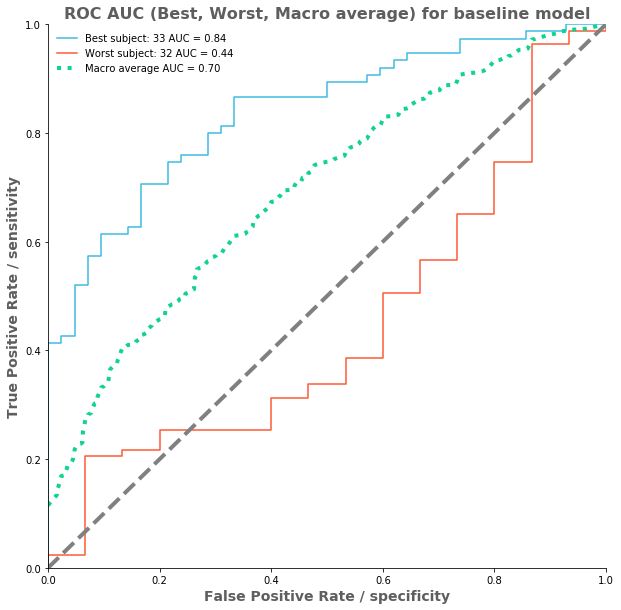

In [19]:
# Plot
plt.figure(figsize=(10,10))
plt.title('ROC AUC (Best, Worst, Macro average) for baseline model', fontweight="bold", fontsize=16, color='#5e5e5e')

# Best subject
plt.plot(fpr_dict[best_subject_nb], tpr_dict[best_subject_nb], color='#3abae3',
         label='Best subject: '+ str(best_subject_nb) +' AUC = %0.2f' % auc_dict[best_subject_nb])

# Worst subject
plt.plot(fpr_dict[worst_subject_nb], tpr_dict[worst_subject_nb], color='#ff5833',
         label='Worst subject: '+ str(worst_subject_nb) +' AUC = %0.2f' % auc_dict[worst_subject_nb])

# Macro average
plt.plot(fpr_dict["macro"], tpr_dict["macro"], linestyle=':', linewidth=4, color='#10d392',
         label='Macro average AUC = %0.2f' % auc_dict["macro"])

plt.legend(loc='best', frameon=False)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=4)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('True Positive Rate / sensitivity', fontweight="bold", fontsize=14, color='#5e5e5e')
plt.xlabel('False Positive Rate / specificity', fontweight="bold", fontsize=14, color='#5e5e5e')
plt.show()

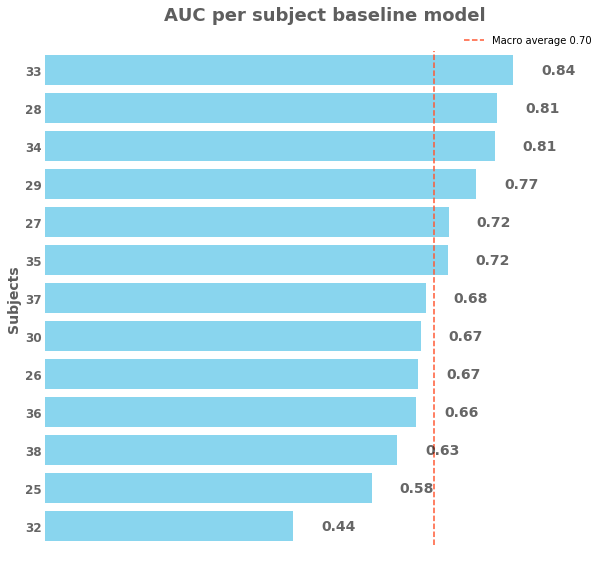

In [109]:
# Plot
plt.figure(figsize=(10,10))

auc_list = []
for subject, auc in auc_dict.items():
    auc_list.append((auc, subject))
auc_list.sort(key=lambda x: x[0])
    
plt.barh(np.arange(len(auc_list)), [e[0] for e in auc_list], color='#3abae3', alpha=0.6)
plt.plot([macro_, macro_], [-0.5, 12.5], '--', color='#ff5833', label='Macro average %0.2f ' % macro_)

# ticks
plt.yticks(np.arange(len(auc_list)), [e[1] for e in auc_list], fontsize=12, fontweight='bold', alpha=0.6)
plt.xticks([], [])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.xlim([0, 1])


# AUC value right
for i, v in enumerate([e[0] for e in auc_list]):
    plt.gca().text(v + 0.05, i - 0.1, str(round(v, 2)), fontweight='bold', fontsize=14, alpha=0.6)

# spineless
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# labels
plt.title('AUC per subject baseline model', fontweight="bold", fontsize=18, color='#5e5e5e')
# plt.xlabel('AUC score', fontweight="bold", fontsize=14, color='#5e5e5e')
plt.ylabel('Subjects', fontweight="bold", fontsize=14, color='#5e5e5e')
plt.legend(loc='best', frameon=False)

plt.show()